In [14]:
##We are going to show an example in how to train a 
# ConvNet from a very large data set (e.g. ImageNet, which contains 1.2 million images with 1000 categories).

#We are going to look at the following cases

# Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, 
# like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

# ConvNet as fixed feature extractor: Here, we will freeze the weights 
# for all of the network except that of the final fully connected layer. 
# This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


# We are going to use the 'cats' and 'dogs' classification challenge to see what we obtain with a pretain network.

# License: BSD
# This work is based on the classification of 'ants' and 'bess' example by  Sasank Chilamkurthy.

# May 21st, 2018

In [15]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode

In [16]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CnDdata'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

###Check why is this not working on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



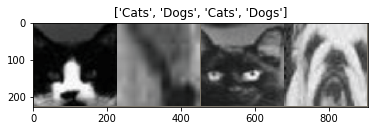

In [17]:
# Visualize a few Images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [18]:
####Finetunning the ConvNet####

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
#Training the model:
# General function to train the model: Two things will happen here
# - scheduling the learning rate
# - Saving the best learning rate

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [20]:
# Function to Visualize the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                #ax = plt.subplot(num_images//18, 18, images_so_far)
                
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
#Finetunning the ConvNet:
#Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6274 Acc: 0.6148
val Loss: 0.4015 Acc: 0.8684

Epoch 1/24
----------
train Loss: 0.5326 Acc: 0.7459
val Loss: 0.2747 Acc: 0.8684

Epoch 2/24
----------
train Loss: 0.4690 Acc: 0.7869
val Loss: 0.2124 Acc: 0.9211

Epoch 3/24
----------
train Loss: 0.5859 Acc: 0.7869
val Loss: 0.3481 Acc: 0.8421

Epoch 4/24
----------
train Loss: 0.5260 Acc: 0.7869
val Loss: 0.2183 Acc: 0.8947

Epoch 5/24
----------
train Loss: 0.4945 Acc: 0.8197
val Loss: 0.3804 Acc: 0.8947

Epoch 6/24
----------
train Loss: 0.5864 Acc: 0.7623
val Loss: 0.2980 Acc: 0.8947

Epoch 7/24
----------
train Loss: 0.3854 Acc: 0.8361
val Loss: 0.2689 Acc: 0.8684

Epoch 8/24
----------
train Loss: 0.3398 Acc: 0.8607
val Loss: 0.2046 Acc: 0.9211

Epoch 9/24
----------
train Loss: 0.3462 Acc: 0.8279
val Loss: 0.3057 Acc: 0.8421

Epoch 10/24
----------
train Loss: 0.3365 Acc: 0.8607
val Loss: 0.2099 Acc: 0.9211

Epoch 11/24
----------
train Loss: 0.4251 Acc: 0.8443
val Loss: 0.2414 Acc: 0.8947

Ep

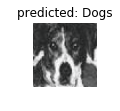

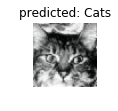

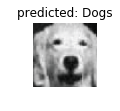

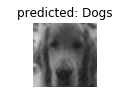

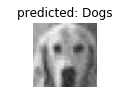

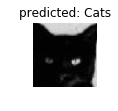

In [23]:
visualize_model(model_ft)

In [24]:
###ConvNet as fixed feature extractor####

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7291 Acc: 0.5820
val Loss: 1.0596 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.6552 Acc: 0.6475
val Loss: 0.3213 Acc: 0.9474

Epoch 2/24
----------
train Loss: 0.6090 Acc: 0.6557
val Loss: 0.3091 Acc: 0.8947

Epoch 3/24
----------
train Loss: 0.4882 Acc: 0.7705
val Loss: 0.3394 Acc: 0.8421

Epoch 4/24
----------
train Loss: 0.7964 Acc: 0.6230
val Loss: 0.2112 Acc: 0.9211

Epoch 5/24
----------
train Loss: 0.7249 Acc: 0.6311
val Loss: 0.4923 Acc: 0.7632

Epoch 6/24
----------
train Loss: 0.5161 Acc: 0.7623
val Loss: 0.2840 Acc: 0.8947

Epoch 7/24
----------
train Loss: 0.5391 Acc: 0.7705
val Loss: 0.2432 Acc: 0.9211

Epoch 8/24
----------
train Loss: 0.4772 Acc: 0.7705
val Loss: 0.2372 Acc: 0.8947

Epoch 9/24
----------
train Loss: 0.4868 Acc: 0.7623
val Loss: 0.2447 Acc: 0.8947

Epoch 10/24
----------
train Loss: 0.4108 Acc: 0.7787
val Loss: 0.2355 Acc: 0.8947

Epoch 11/24
----------
train Loss: 0.3967 Acc: 0.7951
val Loss: 0.2693 Acc: 0.8947

Ep

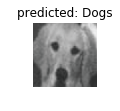

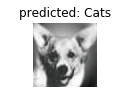

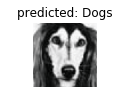

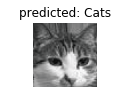

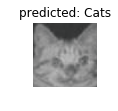

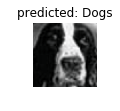

In [26]:
visualize_model(model_conv)

plt.ioff()
plt.show()